# Machine Learning Project: Price prediction for Hostellar

# **Part 1 : Dataset**

In [0]:
#Link the colaboratory with the folder containing the datasets
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive/ECE/ING4/Machine Learning/Projet/")
!ls

# imports
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# show plots in the notebook
%matplotlib inline

Mounted at /content/drive
calendar.csv  listings.csv  seasonal.csv  test.csv  train.csv


In [0]:
#Import some libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import datetime
import warnings
import missingno as msno
warnings.filterwarnings('ignore')
%matplotlib inline

In [0]:
#Import the Dataset

df_train = pd.read_csv("train.csv")
df_train.head()

#df_test = df_train
#to_drop =['SalePrice']
#df_test.drop(to_drop, axis = 1, inplace = True)
#df_test.shape


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
#Description of the dataset
df_train.describe()
print (f"Train has {df_train.shape[0]} rows and {df_train.shape[1]} columns")

Train has 1460 rows and 81 columns


# **Part 2 : Data Cleaning**

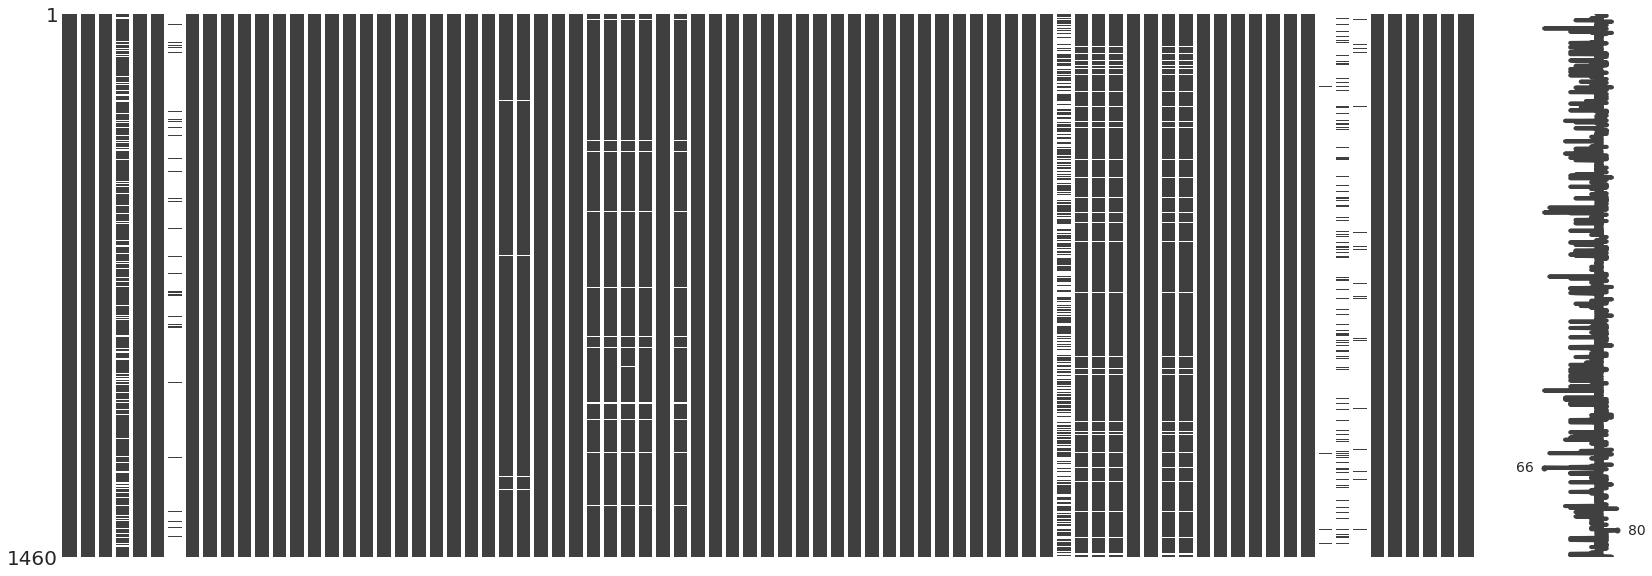

In [0]:
#Show the missing values in the dataset with a picture
#Each line with a value is reprensented by a black line / However, each line in the dataset with no value is represented by a white line
msno.matrix(df_train);

In [0]:
#Function to show the number of null values and their associated percentages
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(df_train)

,Total,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageCond,81,5.55
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55


Observation


1.  Some features have missing values.
2.  Most of the features are object( includes string values in the variable).

There are multiple types of features.


I want to focus on the target variable which is SalePrice. Let's create a histogram to see if the target variable is Normally distributed. If we want to create any linear model, it is essential that the features are normally distributed. This is one of the assumptions of multiple linear regression. I will explain more on this later.



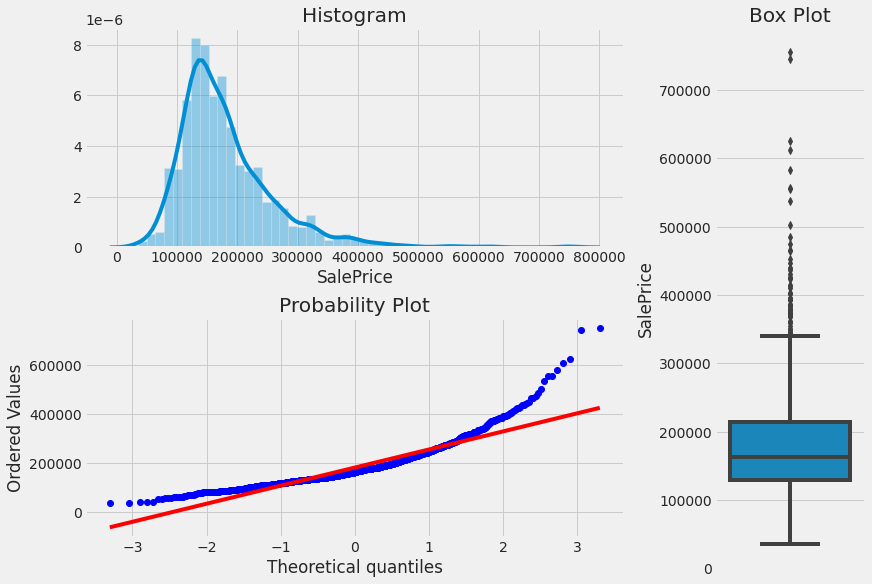

In [0]:
def plotting_3_chart(df, feature):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')
 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('QQ_plot')
    stats.probplot(df.loc[:,feature], plot = ax2)

    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
    
plotting_3_chart(df_train, 'SalePrice')

# **Part 3 : Observations**
*Find out the link between the SalePrice and the others variables

In [0]:
#Function to plot the link and see if there's been a linearity
import matplotlib.style as style
def customized_scatterplot(y, x):
        ## Sizing the plot. 
    style.use('fivethirtyeight')
    plt.subplots(figsize = (12,8))
    ## Plotting target variable with predictor variable(OverallQual)
    sns.scatterplot(y = y, x = x);

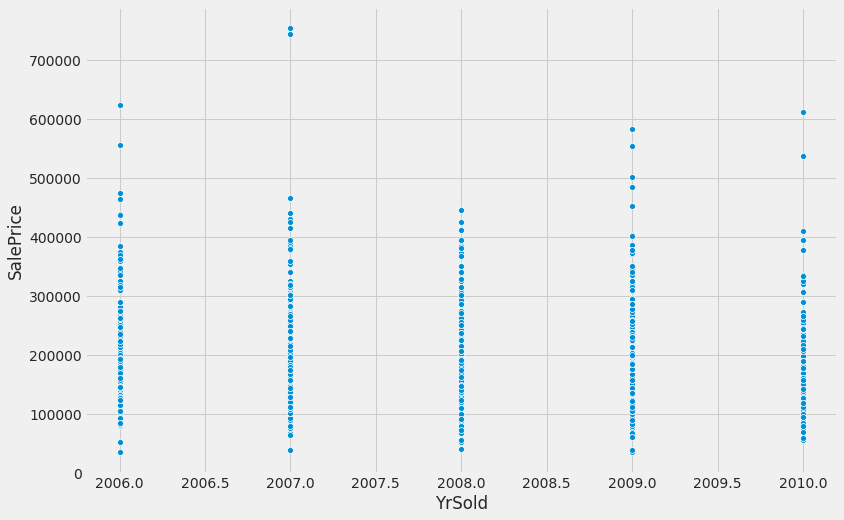

In [0]:

customized_scatterplot(df_train.SalePrice, df_train.YrSold)

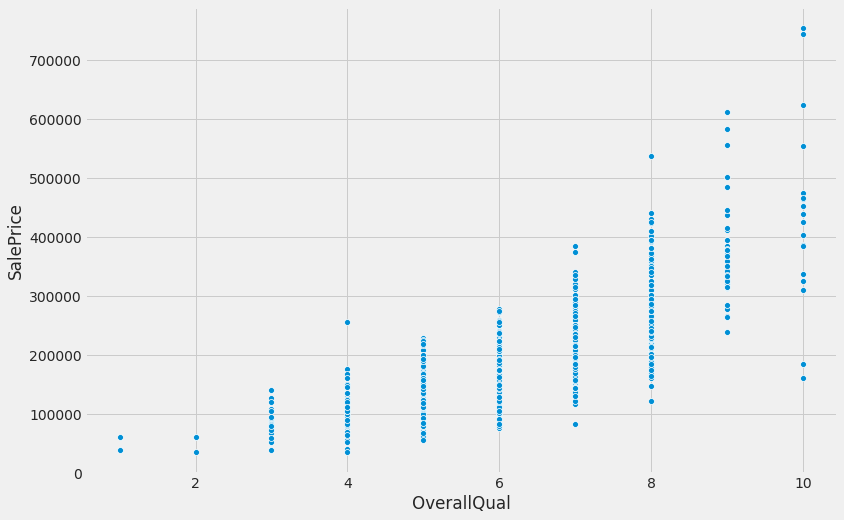

In [0]:
customized_scatterplot(df_train.SalePrice, df_train.OverallQual)

Observations

With the help of these graphs, we can see that not all data are necessarily interesting to keep and analyze.

In [0]:
# Deleting those two values with outliers. 
df_train = df_train[df_train.GrLivArea < 4500]
df_train.reset_index(drop = True, inplace = True)

# save a copy of this dataset so that any changes later on can be compared side by side.
previous_train = df_train.copy()

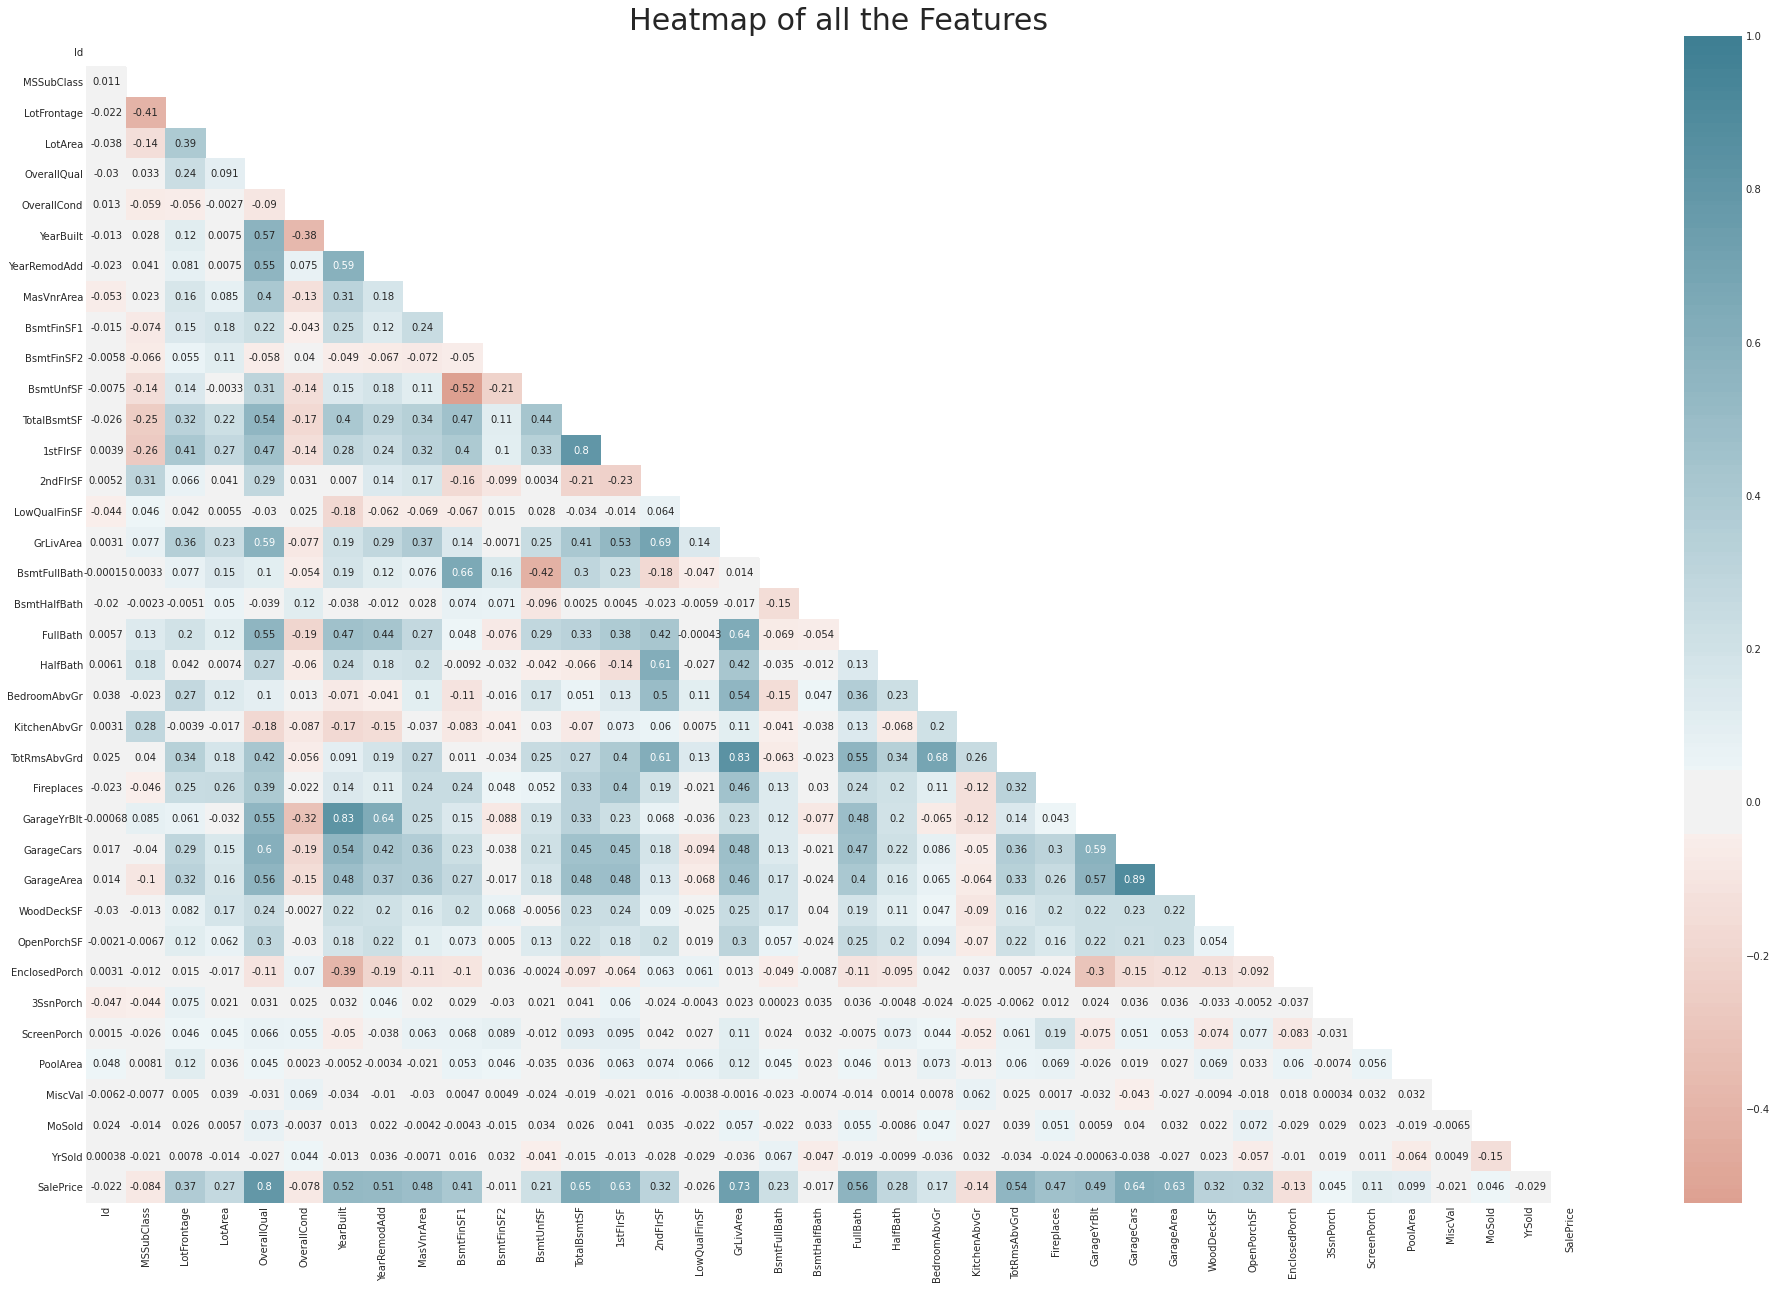

In [0]:
## Plot fig sizing. 
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df_train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(df_train.corr(), 
            cmap=sns.diverging_palette(20, 220, n=200), 
            mask = mask, 
            annot=True, 
            center = 0, 
           );
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 30);

In [0]:
## Some missing values are intentionally left blank, for example: In the Alley feature 
## there are blank values meaning that there are no alley's in that specific house. 
missing_val_col = ["Alley", 
                   "PoolQC", 
                   "MiscFeature",
                   "Fence",
                   "FireplaceQu",
                   "GarageType",
                   "GarageFinish",
                   "GarageQual",
                   "GarageCond",
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2',
                   'MasVnrType']

for i in missing_val_col:
    df_train[i] = df_train[i].fillna('None')

In [0]:
## In the following features the null values are there for a purpose, so we replace them with "0"
missing_val_col2 = ['BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath', 
                    'BsmtHalfBath', 
                    'GarageYrBlt',
                    'GarageArea',
                    'GarageCars',
                    'MasVnrArea']

for i in missing_val_col2:
    df_train[i] = df_train[i].fillna(0)
    
## Replaced all missing values in LotFrontage by imputing the median value of each neighborhood. 
df_train['LotFrontage'] = df_train.groupby('Neighborhood')['LotFrontage'].transform( lambda x: x.fillna(x.mean()))

In [0]:
## Zoning class are given in numerical; therefore converted to categorical variables. 
df_train['MSSubClass'] = df_train['MSSubClass'].astype(str)
df_train['MSZoning'] = df_train.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

## Important years and months that should be categorical variables not numerical. 
# all_data['YearBuilt'] = all_data['YearBuilt'].astype(str)
# all_data['YearRemodAdd'] = all_data['YearRemodAdd'].astype(str)
# all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(str)
df_train['YrSold'] = df_train['YrSold'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str) 

In [0]:
df_train['Functional'] = df_train['Functional'].fillna('Typ') 
df_train['Utilities'] = df_train['Utilities'].fillna('AllPub') 
df_train['Exterior1st'] = df_train['Exterior1st'].fillna(df_train['Exterior1st'].mode()[0]) 
df_train['Exterior2nd'] = df_train['Exterior2nd'].fillna(df_train['Exterior2nd'].mode()[0])
df_train['KitchenQual'] = df_train['KitchenQual'].fillna("TA") 
df_train['SaleType'] = df_train['SaleType'].fillna(df_train['SaleType'].mode()[0])
df_train['Electrical'] = df_train['Electrical'].fillna("SBrkr") 

In [0]:
missing_percentage(df_train)

,Total,Percent


In [0]:
df_train['haspool'] = df_train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_train['has2ndfloor'] = df_train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_train['hasgarage'] = df_train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_train['hasbsmt'] = df_train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_train['hasfireplace'] = df_train['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [0]:
df_train.shape

(1458, 86)

In [0]:
df_train = df_train.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

In [0]:
#DROP
df_train.drop(columns=['Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','Fence','MiscFeature','SaleType','SaleCondition','BsmtFinType1','MSSubClass','MSZoning','LotFrontage','LotArea','Alley','LotShape','LandContour','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallCond','YearBuilt','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea','ExterQual','ExterCond','BsmtFinType1','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtHalfBath','HalfBath','TotRmsAbvGrd','GarageYrBlt','GarageCars','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','haspool','has2ndfloor','hasgarage','hasbsmt','hasfireplace','Id'],axis=1, inplace=True)

In [0]:
df_train.drop(columns=['BsmtFinType1','MSSubClass','MSZoning','LotFrontage','LotArea','Alley','LotShape','LandContour','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallCond','YearBuilt','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea','ExterQual','ExterCond','BsmtFinType1','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtHalfBath','HalfBath','TotRmsAbvGrd','GarageYrBlt','GarageCars','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal'],axis=1, inplace=True)

In [0]:
df_train.drop(columns=['haspool','has2ndfloor','hasgarage','hasbsmt','hasfireplace'],axis=1, inplace=True)

In [0]:
df_train.drop(columns=['Id'],axis=1, inplace=True)

In [0]:
df_train.shape

(1458, 11)

In [0]:
df_train.head(3)

,Street,Utilities,OverallQual,TotalBsmtSF,BsmtFullBath,FullBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageArea,PoolQC,MoSold,YrSold,SalePrice
0,Pave,AllPub,7,856,1,2,3,1,0,548,None,2,2008,208500
1,Pave,AllPub,6,1262,0,2,3,1,1,460,None,5,2007,181500
2,Pave,AllPub,7,920,1,2,3,1,1,608,None,9,2008,223500


In [0]:
#Linear Regression
y = df_train.SalePrice
X = df_train.drop('SalePrice', axis=1, inplace=False)
from sklearn.model_selection import train_test_split
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print("train set shape: ", X_train.shape, y_train.shape)
print("test set shape: ", X_test.shape, y_test.shape)
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)
train_score = reg.score(X_train, y_train)
test_score=reg.score(X_test, y_test)
print  ('train score =', train_score)
print  ('test score = {}'.format(test_score))

(1458, 10)
(1458,)
train set shape:  (1020, 10) (1020,)
test set shape:  (438, 10) (438,)
train score = 0.7663877018089571
test score = 0.775267699064265


In [0]:
#Logistic Regression
y = df_train.SalePrice
X = df_train.drop('SalePrice', axis=1, inplace=False)
from sklearn.model_selection import train_test_split
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print("train set shape: ", X_train.shape, y_train.shape)
print("test set shape: ", X_test.shape, y_test.shape)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=1)
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score=clf.score(X_test, y_test)
print  ('train score =', train_score)
print  ('test score = {}'.format(test_score))

(1458, 10)
(1458,)
train set shape:  (1020, 10) (1020,)
test set shape:  (438, 10) (438,)
train score = 0.04607843137254902
test score = 0.01598173515981735


In [0]:
!pip install flask-ngrok
!pip install -U flask-cors

from flask import Flask
from flask import request
from flask_cors import CORS
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
CORS(app)
run_with_ngrok(app)  # Start ngrok when app is run

# for / root, return Hello Word
@app.route("/result/<int:OverallQual>/<int:TotalBsmtSF>/<int:BsmtFullBath>/<int:FullBath>/<int:BedroomAbvGr>/<int:KitchenAbvGr>/<int:Fireplaces>/<int:GarageArea>/<int:MoSold>/<int:YrSold>")
def root(OverallQual, TotalBsmtSF, BsmtFullBath, FullBath, BedroomAbvGr, KitchenAbvGr, Fireplaces, GarageArea, MoSold, YrSold):
    df_trainbis = [OverallQual, TotalBsmtSF, BsmtFullBath, FullBath, BedroomAbvGr, KitchenAbvGr, Fireplaces, GarageArea, MoSold, YrSold]
    df = pd.DataFrame(np.array(df_trainbis).reshape(1,-1), columns=df_trainbis)
    reg = LinearRegression().fit(X_train, y_train)
    return f"{ reg.predict(df)[0]}"

app.run()

Requirement already up-to-date: flask-cors in /usr/local/lib/python3.6/dist-packages (3.0.8)
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://e99aa258.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [24/Apr/2020 00:29:48] "GET /result/8/200/2/2/2/3/2/20/3/2008 HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2020 00:29:49] "GET /result/8/200/2/2/2/3/2/20/3/2008 HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2020 00:55:15] "GET /result/8/150/2/2/3/1/1/25/08/2010 HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2020 00:55:26] "GET /result/8/150/2/2/3/1/1/25/08/2010 HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2020 01:00:44] "GET /result/8/150/2/1/3/1/1/25/11/2018 HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2020 01:00:54] "GET /result/8/150/2/1/3/1/1/25/11/2018 HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2020 01:05:21] "GET /result/8/150/2/1/3/1/1/25/11/2018 HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2020 01:05:35] "GET /result/8/150/2/1/3/1/1/25/11/2018 HTTP/1.1" 200 -


In [0]:
#Test de la prédiction
print(test11)
test22 = pd.DataFrame(np.array(test11).reshape(1,-1), columns=test11)
reg.predict(test22)[0]

[8, 100, 3, 2, 2, 20, 11, 2002]


232078.2714126358

# --------------------------------------------------------------------------------------------------------------------------------------

In [0]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

NameError: ignored

In [0]:
## Train test s
from sklearn.model_selection import train_test_split
## Train test split follows this distinguished code pattern and helps creating train and test set to build machine learning. 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .33, random_state = 0)
reg = LinearRegression()
reg.fit(X_train, y_train)
train_score = reg.score(X_train, y_train)
test_score=reg.score(X_test, y_test)

print  ('train score =', train_score)
print  ('test score = {}'.format(test_score))

ValueError: ignored

MA PARTIE : 

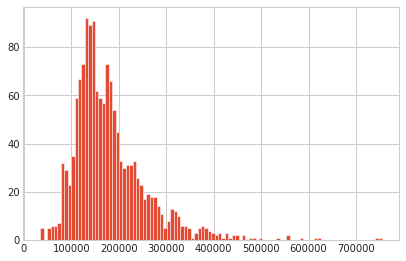

In [0]:
#Apprentissage

y = df_train.SalePrice
X = df_train.drop('SalePrice', axis=1, inplace=False)
y.hist(bins=100)


In [0]:
from sklearn.model_selection import train_test_split
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print("train set shape: ", X_train.shape, y_train.shape)
print("test set shape: ", X_test.shape, y_test.shape)

(1458, 80)
(1458,)
train set shape:  (1020, 80) (1020,)
test set shape:  (438, 80) (438,)


In [0]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)
train_score = reg.score(X_train, y_train)
test_score=reg.score(X_test, y_test)
print  ('train score =', train_score)
print  ('test score = {}'.format(test_score))

ValueError: ignored